# Notebook 06: Tour Cost Analysis

**Traveco Transport Forecasting Project**

## Objective
Analyze tour-level costs and efficiency:
1. Load tour assignments data (Tourenaufstellung)
2. Calculate vehicle costs: (KM cost × distance) + (minute cost × time)
3. Compare actual driven km vs billed km efficiency
4. Join tour costs with orders
5. Aggregate costs by branch/Auftraggeber
6. Create cost efficiency metrics

## Outputs
- `data/processed/tour_costs.csv` - Tour-level cost data
- `data/processed/orders_with_tour_costs.csv` - Orders with joined tour costs
- Cost analysis visualizations

---

## 1. Setup and Imports

In [27]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pathlib import Path
import warnings

# Custom utilities
import sys
sys.path.append('..')  # Add parent directory to path
from utils.traveco_utils import (
    ConfigLoader,
    TravecomDataLoader,
    load_processed_data,
    save_processed_data
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Setup complete!")

Setup complete!


## 2. Load Data

In [28]:
# Load configuration
config = ConfigLoader('../config/config.yaml')

# Load tour assignments
loader = TravecomDataLoader(config)
print("Loading tour assignments data...")
df_tours = loader.load_tour_assignments()

print(f"\nLoaded {len(df_tours):,} tour assignments")
print(f"Columns ({len(df_tours.columns)}): {list(df_tours.columns)}")

Loading tour assignments data...
Loading tour assignments from: ../data/swisstransfer_f473fe80-56b4-4ff0-8cbb-1bb5e181450a/20251015 QS Tourenaufstellung Juni 2025.xlsx
Loaded 14,241 tour assignments

Loaded 14,241 tour assignments
Columns (34): ['Datum Tour', 'Nummer.Tour', 'Tour Bezeichnung', 'TourTyp.Tour', 'System_id.Auftrag', 'Nr Fahrzeug', 'Nr Spedition', 'Name Spedition', 'Nr. Fhz Typ', 'Bezeichnung.Fahrzeugtyp', 'PC KM Kosten', 'PC Minuten Kosten', 'Anz. Empfänger', '# Aufträge', '∑ Frachtpfl. Gewicht', '∑ Gewicht', 'Rückerfasste KM AHZ', 'Rückerfasste Solo Km', 'Rückerfasste Tour Stunden', 'Soll KM PraCar', 'IstKm.Tour', 'IST Zeit PraCar', 'Fahrzeit Tour', 'Standzeit Tour', 'Arbeitszeit Chauffeur', 'Ist Tour Begin', 'Ist Tour Ende', 'Tour End (errechnet)', 'Anz RC', 'Anz RC (TISLOG / PRABORD)', 'Anz RC (ohne TISLOG / PRABORD)', 'Alles in EH', 'Alles in EH (TISLOG & PRABORD)', 'Alles in EH ( ohne TISLOG & PRABORD)']


In [29]:
# Display sample data
print("\n=== Sample Tour Data ===")
df_tours.head(10)


=== Sample Tour Data ===


,Datum Tour,Nummer.Tour,Tour Bezeichnung,TourTyp.Tour,System_id.Auftrag,Nr Fahrzeug,Nr Spedition,Name Spedition,Nr. Fhz Typ,Bezeichnung.Fahrzeugtyp,PC KM Kosten,PC Minuten Kosten,Anz. Empfänger,# Aufträge,∑ Frachtpfl. Gewicht,∑ Gewicht,Rückerfasste KM AHZ,Rückerfasste Solo Km,Rückerfasste Tour Stunden,Soll KM PraCar,IstKm.Tour,IST Zeit PraCar,Fahrzeit Tour,Standzeit Tour,Arbeitszeit Chauffeur,Ist Tour Begin,Ist Tour Ende,Tour End (errechnet),Anz RC,Anz RC (TISLOG / PRABORD),Anz RC (ohne TISLOG / PRABORD),Alles in EH,Alles in EH (TISLOG & PRABORD),Alles in EH ( ohne TISLOG & PRABORD)
0,2025-06-01,566888,6140_1,SH,TRP,3. FX6,9126,FruchtXpress GmbH,29,**INAKTIV ab'23_Fremd 2-Achser Kühl,0.956,0.346,22,56,8604.22,8604.22,0,460,8.5,129,0,4.016667,3.000000,1.016667,0.0,5.083333,22.033333,9.1,51.00,0,51.00,25.50,0.0,25.50
1,2025-06-01,557269,2134 Kuoni Samedan,FD,TRP,7.Rhb Zug,9249,Rhätische Bahn AG Güterverkehr,-,-,-,-,5,15,3179.77,3179.77,0,0,0,109,0,2.633333,2.150000,0.483333,0.0,5,14.366667,7.633333,19.00,0,19.00,9.50,0.0,9.50
2,2025-06-01,557265,2130 Kuoni Samedan,FD,TRP,7.Rhb Zug,9249,Rhätische Bahn AG Güterverkehr,-,-,-,-,6,15,2345.69,2345.69,0,0,0,109,0,2.566667,2.150000,0.416667,0.0,5,16.9,7.566667,15.00,0,15.00,7.50,0.0,7.50
3,2025-06-01,557271,2136 Westreicher,FD,TRP,7.Rhb Zug,9249,Rhätische Bahn AG Güterverkehr,-,-,-,-,5,13,1271.71,1271.71,0,0,0,109,0,2.483333,2.150000,0.333333,0.0,5,16.416667,7.483333,10.00,0,10.00,5.00,0.0,5.00
4,2025-06-01,557273,2138 Westreicher,FD,TRP,7.Rhb Zug,9249,Rhätische Bahn AG Güterverkehr,-,-,-,-,3,8,956.17,956.17,0,0,0,109,0,2.433333,2.150000,0.283333,0.0,5,13.883333,7.433333,7.00,0,7.00,3.50,0.0,3.50
5,2025-06-01,557267,2133 Kuoni Samedan,FD,TRP,7.Rhb Zug,9249,Rhätische Bahn AG Güterverkehr,-,-,-,-,2,4,829.94,829.94,0,0,0,109,0,2.416667,2.150000,0.266667,0.0,10,13.85,12.416667,6.00,0,6.00,3.00,0.0,3.00
6,2025-06-02,814914,1/101,Normal,B&T,1.01~20210113,1100,B&T Winterthur,14,BT 5-Achs-Anhzug,0.001,0.001,1,13,0.00,56635.69,0,0,0,109,0,7.433333,3.133333,4.300000,0.0,5,13.683333,12.433333,1305.20,0,1305.20,652.60,0.0,652.60
7,2025-06-02,814940,1/102,Normal,B&T,1.02~20210329,1100,B&T Winterthur,16,BT Schlepper,0.001,0.001,4,16,0.00,164566.38,0,0,0,182,0,12.750000,4.250000,8.500000,0.0,5,19.25,17.75,4138.06,0,4138.06,2069.03,0.0,2069.03
8,2025-06-02,814915,1/103,Normal,B&T,1.03~20220117,1100,B&T Winterthur,13,BT 4-Achser,0.001,0.001,4,15,0.00,71091.11,0,0,0,132,0,9.533333,4.050000,5.483333,0.0,5,16.033333,14.533333,1574.06,0,1574.06,787.03,0.0,787.03
9,2025-06-02,814941,1/104HVO,Normal,B&T,1.04~20170825,1100,B&T Winterthur,15,BT 5-Achser,0.001,0.001,3,7,0.00,91060.82,0,0,0,293,0,10.483333,5.633333,4.850000,0.0,5,16.983333,15.483333,2166.58,0,2166.58,1083.29,0.0,1083.29


## 3. Calculate Vehicle Costs

**Formula**: `Vehicle Cost = (Fahrzeug KM × PC KM Kosten) + (IST Zeit PraCar × 60 × PC Minuten Kosten)`

Where:
- **Fahrzeug KM** (Column K or similar): Actual kilometers driven
- **PC KM Kosten** (Column K): Cost per kilometer
- **IST Zeit PraCar** (Column V): Actual time in hours (digital format)
- **PC Minuten Kosten** (Column L): Cost per minute

In [30]:
# Identify cost columns
print("Identifying cost columns...")
print(f"\nAvailable columns: {list(df_tours.columns)}")

# Map column names
cost_columns = {
    'km_cost': None,
    'minute_cost': None,
    'actual_km': None,
    'actual_time_hours': None
}

# Find KM cost column
for col in ['PC KM Kosten', 'KM Kosten', 'Kosten_KM']:
    if col in df_tours.columns:
        cost_columns['km_cost'] = col
        break

# Find minute cost column
for col in ['PC Minuten Kosten', 'Minuten Kosten', 'Kosten_Minuten']:
    if col in df_tours.columns:
        cost_columns['minute_cost'] = col
        break

# Find actual KM column
for col in ['IstKm.Tour', 'Ist KM', 'Fahrzeug KM', 'Rückerfasste KM']:
    if col in df_tours.columns:
        cost_columns['actual_km'] = col
        break

# Find actual time column (in hours)
for col in ['IST Zeit PraCar', 'Ist Zeit', 'Rückerfasste Tour Stunden']:
    if col in df_tours.columns:
        cost_columns['actual_time_hours'] = col
        break

print(f"\nMapped cost columns:")
for key, val in cost_columns.items():
    status = "✓" if val else "✗"
    print(f"  {status} {key}: {val}")

Identifying cost columns...

Available columns: ['Datum Tour', 'Nummer.Tour', 'Tour Bezeichnung', 'TourTyp.Tour', 'System_id.Auftrag', 'Nr Fahrzeug', 'Nr Spedition', 'Name Spedition', 'Nr. Fhz Typ', 'Bezeichnung.Fahrzeugtyp', 'PC KM Kosten', 'PC Minuten Kosten', 'Anz. Empfänger', '# Aufträge', '∑ Frachtpfl. Gewicht', '∑ Gewicht', 'Rückerfasste KM AHZ', 'Rückerfasste Solo Km', 'Rückerfasste Tour Stunden', 'Soll KM PraCar', 'IstKm.Tour', 'IST Zeit PraCar', 'Fahrzeit Tour', 'Standzeit Tour', 'Arbeitszeit Chauffeur', 'Ist Tour Begin', 'Ist Tour Ende', 'Tour End (errechnet)', 'Anz RC', 'Anz RC (TISLOG / PRABORD)', 'Anz RC (ohne TISLOG / PRABORD)', 'Alles in EH', 'Alles in EH (TISLOG & PRABORD)', 'Alles in EH ( ohne TISLOG & PRABORD)']

Mapped cost columns:
  ✓ km_cost: PC KM Kosten
  ✓ minute_cost: PC Minuten Kosten
  ✓ actual_km: IstKm.Tour
  ✓ actual_time_hours: IST Zeit PraCar


In [31]:
# Calculate vehicle costs
print("Calculating vehicle costs...\n")

# Ensure numeric types
for key, col in cost_columns.items():
    if col and col in df_tours.columns:
        df_tours[col] = pd.to_numeric(df_tours[col], errors='coerce')
        print(f"{col}:")
        print(f"  Type: {df_tours[col].dtype}")
        
        # Handle formatting safely
        min_val = df_tours[col].min()
        max_val = df_tours[col].max()
        mean_val = df_tours[col].mean()
        
        if pd.notna(min_val):
            print(f"  Min: {min_val:.2f}")
        else:
            print(f"  Min: N/A")
            
        if pd.notna(max_val):
            print(f"  Max: {max_val:.2f}")
        else:
            print(f"  Max: N/A")
            
        if pd.notna(mean_val):
            print(f"  Mean: {mean_val:.2f}")
        else:
            print(f"  Mean: N/A")
        print()

# Calculate costs
if all(cost_columns.values()):
    # KM cost component
    df_tours['km_cost_component'] = (
        df_tours[cost_columns['actual_km']] * 
        df_tours[cost_columns['km_cost']]
    )
    
    # Time cost component (convert hours to minutes × minute cost)
    df_tours['time_cost_component'] = (
        df_tours[cost_columns['actual_time_hours']] * 60 * 
        df_tours[cost_columns['minute_cost']]
    )
    
    # Total vehicle cost
    df_tours['vehicle_cost'] = (
        df_tours['km_cost_component'] + 
        df_tours['time_cost_component']
    )
    
    print("\n✓ Vehicle costs calculated")
    print(f"\nCost statistics:")
    print(df_tours[['km_cost_component', 'time_cost_component', 'vehicle_cost']].describe())
    
else:
    print("\n⚠️  Cannot calculate vehicle costs - missing required columns")
    missing = [k for k, v in cost_columns.items() if not v]
    print(f"   Missing: {missing}")

Calculating vehicle costs...

PC KM Kosten:
  Type: float64
  Min: 0.00
  Max: 1.40
  Mean: 0.98

PC Minuten Kosten:
  Type: float64
  Min: 0.00
  Max: 1.35
  Mean: 0.67

IstKm.Tour:
  Type: float64
  Min: 0.00
  Max: 583.00
  Mean: 28.67

IST Zeit PraCar:
  Type: float64
  Min: 0.00
  Max: 28.70
  Mean: 5.65


✓ Vehicle costs calculated

Cost statistics:
       km_cost_component  time_cost_component  vehicle_cost
count       12893.000000         12893.000000  12893.000000
mean           32.040957           203.100004    235.140962
std            79.979913           129.520275    162.182897
min             0.000000             0.038000      0.038000
25%             0.000000           115.024000    121.770000
50%             0.000000           196.992000    217.115000
75%             0.000000           281.940000    330.030000
max           629.640000          1118.070000   1118.070000


## 4. Kilometer Efficiency Analysis

Compare actual driven km vs billed km (sum of order distances)

In [32]:
# Load orders to get billed distances
print("Loading orders data to calculate billed km...")
df_orders = load_processed_data('features_engineered.csv', config)

print(f"Loaded {len(df_orders):,} orders")

# Aggregate billed km by tour
if 'Nummer.Tour' in df_orders.columns and 'Distanz_BE.Auftrag' in df_orders.columns:
    billed_km_by_tour = df_orders.groupby('Nummer.Tour').agg({
        'Distanz_BE.Auftrag': 'sum',
        'Nummer.Auftrag': 'count'
    }).reset_index()
    
    billed_km_by_tour.columns = ['Nummer.Tour', 'billed_km_total', 'order_count']
    
    # Join with tours
    df_tours = df_tours.merge(billed_km_by_tour, on='Nummer.Tour', how='left')
    
    print(f"\n✓ Joined billed km data")
    print(f"  Tours with billed data: {df_tours['billed_km_total'].notna().sum():,}")
    
    # Calculate efficiency ratio
    if cost_columns['actual_km']:
        df_tours['km_efficiency_ratio'] = (
            df_tours[cost_columns['actual_km']] / df_tours['billed_km_total']
        )
        
        print(f"\nKM Efficiency Ratio (Actual / Billed):")
        print(f"  Mean: {df_tours['km_efficiency_ratio'].mean():.3f}")
        print(f"  Median: {df_tours['km_efficiency_ratio'].median():.3f}")
        print(f"  Good efficiency (<1.0): {(df_tours['km_efficiency_ratio'] < 1.0).sum():,} tours")
        print(f"  Poor efficiency (>1.2): {(df_tours['km_efficiency_ratio'] > 1.2).sum():,} tours")
else:
    print("\n⚠️  Cannot calculate km efficiency - missing columns")

Loading orders data to calculate billed km...
Loaded 135,646 rows from: ../data/processed/features_engineered.csv
Loaded 135,646 orders

✓ Joined billed km data
  Tours with billed data: 694

KM Efficiency Ratio (Actual / Billed):
  Mean: 0.641
  Median: 0.000
  Good efficiency (<1.0): 633 tours
  Poor efficiency (>1.2): 7 tours


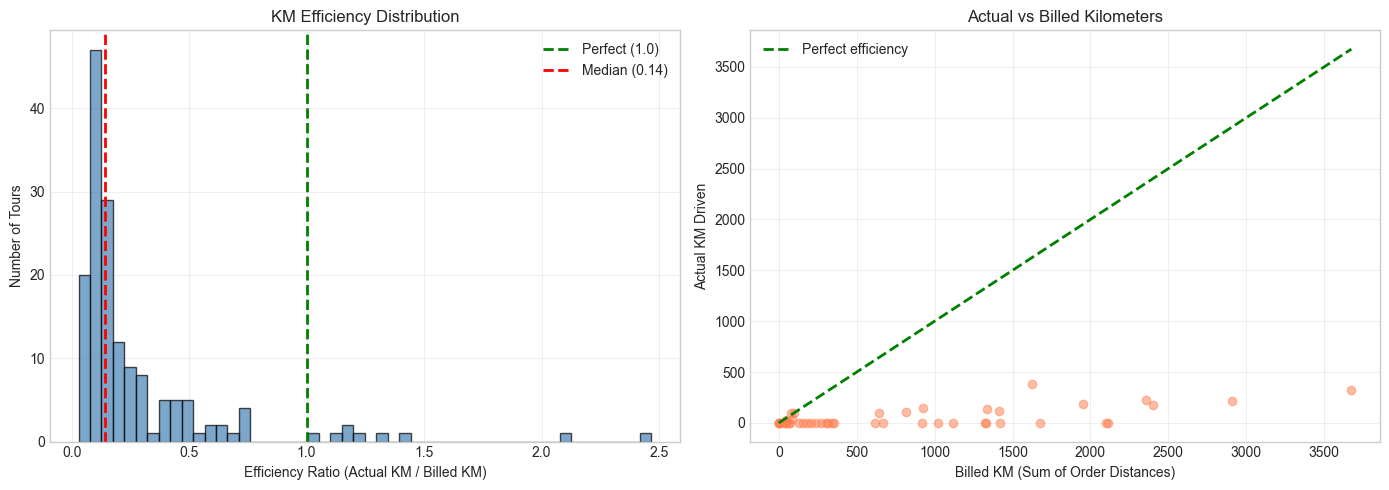

In [33]:
# Visualize KM efficiency
if 'km_efficiency_ratio' in df_tours.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of efficiency ratio
    efficiency_clean = df_tours['km_efficiency_ratio'].dropna()
    efficiency_clean = efficiency_clean[(efficiency_clean > 0) & (efficiency_clean < 3)]  # Filter outliers
    
    axes[0].hist(efficiency_clean, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(x=1.0, color='green', linestyle='--', linewidth=2, label='Perfect (1.0)')
    axes[0].axvline(x=efficiency_clean.median(), color='red', linestyle='--', linewidth=2, label=f'Median ({efficiency_clean.median():.2f})')
    axes[0].set_xlabel('Efficiency Ratio (Actual KM / Billed KM)')
    axes[0].set_ylabel('Number of Tours')
    axes[0].set_title('KM Efficiency Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter: actual vs billed km
    sample = df_tours.sample(min(1000, len(df_tours)))
    axes[1].scatter(sample['billed_km_total'], sample[cost_columns['actual_km']], 
                   alpha=0.5, color='coral')
    
    # Add perfect efficiency line (y=x)
    max_km = max(sample['billed_km_total'].max(), sample[cost_columns['actual_km']].max())
    axes[1].plot([0, max_km], [0, max_km], 'g--', linewidth=2, label='Perfect efficiency')
    
    axes[1].set_xlabel('Billed KM (Sum of Order Distances)')
    axes[1].set_ylabel('Actual KM Driven')
    axes[1].set_title('Actual vs Billed Kilometers')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Cost Analysis by Branch/Carrier

In [34]:
# Join tours with orders to get Auftraggeber
print("Joining tour costs with orders...")

# Keep only necessary columns from tours
tour_cost_cols = ['Nummer.Tour', 'vehicle_cost', 'km_cost_component', 'time_cost_component',
                 'km_efficiency_ratio', 'billed_km_total', 'order_count']

# Add actual km if available
if cost_columns['actual_km']:
    tour_cost_cols.append(cost_columns['actual_km'])

available_tour_cols = [col for col in tour_cost_cols if col in df_tours.columns]
df_tour_costs = df_tours[available_tour_cols].copy()

# Join with orders
df_orders_with_costs = df_orders.merge(df_tour_costs, on='Nummer.Tour', how='left')

print(f"\n✓ Joined tour costs with orders")
print(f"  Orders with cost data: {df_orders_with_costs['vehicle_cost'].notna().sum():,}")
print(f"  Percentage: {df_orders_with_costs['vehicle_cost'].notna().sum() / len(df_orders_with_costs) * 100:.1f}%")

Joining tour costs with orders...

✓ Joined tour costs with orders
  Orders with cost data: 7,838
  Percentage: 5.8%


In [35]:
# Aggregate costs by Betriebszentrale (dispatch center)
if 'betriebszentrale_name' in df_orders_with_costs.columns:
    print("Aggregating costs by Betriebszentrale (dispatch center)...")
    
    costs_by_branch = df_orders_with_costs.groupby('betriebszentrale_name').agg({
        'vehicle_cost': 'sum',
        'km_cost_component': 'sum',
        'time_cost_component': 'sum',
        'Nummer.Auftrag': 'count',
        'Distanz_BE.Auftrag': 'sum'
    }).reset_index()
    
    costs_by_branch.columns = ['Betriebszentrale', 'total_vehicle_cost', 'total_km_cost', 
                                'total_time_cost', 'order_count', 'total_distance_km']
    
    # Calculate cost per order
    costs_by_branch['cost_per_order'] = (
        costs_by_branch['total_vehicle_cost'] / costs_by_branch['order_count']
    )
    
    # Calculate cost per km
    costs_by_branch['cost_per_km'] = (
        costs_by_branch['total_vehicle_cost'] / costs_by_branch['total_distance_km']
    )
    
    # Sort by total cost
    costs_by_branch = costs_by_branch.sort_values('total_vehicle_cost', ascending=False)
    
    print(f"\n✓ Cost aggregation complete")
    print(f"\nTop 10 branches by total vehicle cost:")
    print(costs_by_branch.head(10))
    
    # Save aggregated costs
    save_processed_data(costs_by_branch, 'costs_by_auftraggeber.csv', config)
    
else:
    print("\n⚠️  betriebszentrale_name column not found (run Notebook 03 with Betriebszentralen mapping)")


Aggregating costs by Auftraggeber (order owner)...

✓ Cost aggregation complete

Top 10 branches by total vehicle cost:
   Auftraggeber  total_vehicle_cost  total_km_cost  total_time_cost  \
6          3000         1377487.304     646391.779       731095.525   
7          4000          641294.200     161185.388       480108.812   
8          5000          580934.390       4703.413       576230.977   
11         7000          254557.532      98196.721       156360.811   
5          1900          116845.715      55937.403        60908.312   
9          6000           69269.475          0.000        69269.475   
10         6040           39916.379        591.660        39324.719   
3          1500            4861.016        397.122         4463.894   
1          1100              15.161          0.000           15.161   
4          1600               1.771          0.000            1.771   

    order_count  total_distance_km  cost_per_order  cost_per_km  
6         35980          2524066

## 6. Cost Visualizations

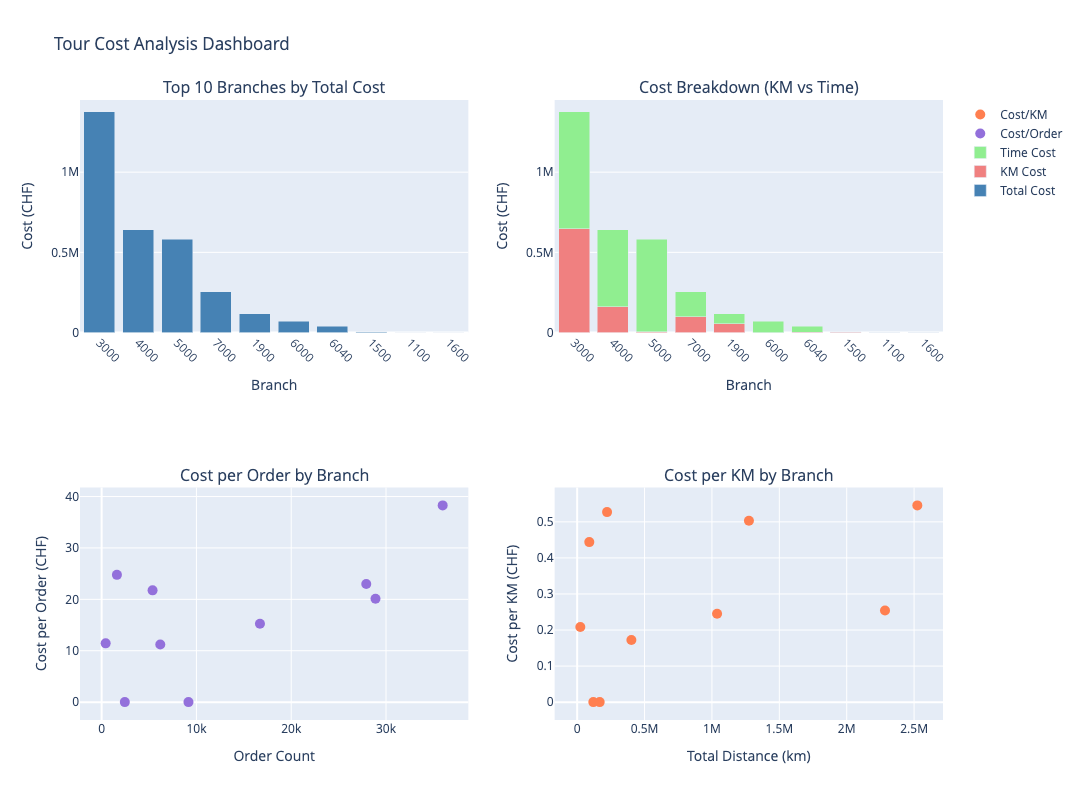


✓ Dashboard saved to: results/tour_cost_dashboard.html


In [36]:
# Create comprehensive cost dashboard
if 'costs_by_branch' in locals():
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Top 10 Branches by Total Cost',
            'Cost Breakdown (KM vs Time)',
            'Cost per Order by Branch',
            'Cost per KM by Branch'
        ),
        specs=[[{'type': 'bar'}, {'type': 'bar'}],
               [{'type': 'scatter'}, {'type': 'scatter'}]]
    )
    
    top10 = costs_by_branch.head(10)
    
    # 1. Total cost by branch
    fig.add_trace(
        go.Bar(x=top10['Betriebszentrale'], y=top10['total_vehicle_cost'],
               marker_color='steelblue', name='Total Cost'),
        row=1, col=1
    )
    
    # 2. Cost breakdown
    fig.add_trace(
        go.Bar(x=top10['Betriebszentrale'], y=top10['total_km_cost'],
               marker_color='lightcoral', name='KM Cost'),
        row=1, col=2
    )
    fig.add_trace(
        go.Bar(x=top10['Betriebszentrale'], y=top10['total_time_cost'],
               marker_color='lightgreen', name='Time Cost'),
        row=1, col=2
    )
    
    # 3. Cost per order
    fig.add_trace(
        go.Scatter(x=top10['order_count'], y=top10['cost_per_order'],
                  mode='markers', marker=dict(size=10, color='mediumpurple'),
                  name='Cost/Order'),
        row=2, col=1
    )
    
    # 4. Cost per km
    fig.add_trace(
        go.Scatter(x=top10['total_distance_km'], y=top10['cost_per_km'],
                  mode='markers', marker=dict(size=10, color='coral'),
                  name='Cost/KM'),
        row=2, col=2
    )
    
    # Update layout
    fig.update_xaxes(title_text="Branch", row=1, col=1, tickangle=45)
    fig.update_xaxes(title_text="Branch", row=1, col=2, tickangle=45)
    fig.update_xaxes(title_text="Order Count", row=2, col=1)
    fig.update_xaxes(title_text="Total Distance (km)", row=2, col=2)
    
    fig.update_yaxes(title_text="Cost (CHF)", row=1, col=1)
    fig.update_yaxes(title_text="Cost (CHF)", row=1, col=2)
    fig.update_yaxes(title_text="Cost per Order (CHF)", row=2, col=1)
    fig.update_yaxes(title_text="Cost per KM (CHF)", row=2, col=2)
    
    fig.update_layout(
        height=800,
        showlegend=True,
        title_text="Tour Cost Analysis Dashboard",
        barmode='stack'
    )
    
    fig.write_html('../results/tour_cost_dashboard.html')
    fig.show()
    
    print("\n✓ Dashboard saved to: results/tour_cost_dashboard.html")


## 7. Save Results

In [37]:
# Save tour costs
print("Saving processed data...")

# 1. Tour-level costs
save_processed_data(df_tours, 'tour_costs.csv', config)

# 2. Orders with tour costs
save_processed_data(df_orders_with_costs, 'orders_with_tour_costs.csv', config)

print("\n✓ All data saved successfully!")

Saving processed data...
Saved 14,241 rows to: ../data/processed/tour_costs.csv
Saved 135,646 rows to: ../data/processed/orders_with_tour_costs.csv

✓ All data saved successfully!


## 8. Summary Report

In [38]:
print("=" * 80)
print("TOUR COST ANALYSIS SUMMARY")
print("=" * 80)

if 'vehicle_cost' in df_tours.columns:
    print(f"\n💰 VEHICLE COSTS:")
    print(f"   Total tours analyzed: {len(df_tours):,}")
    print(f"   Tours with costs: {df_tours['vehicle_cost'].notna().sum():,}")
    print(f"   Total vehicle cost: CHF {df_tours['vehicle_cost'].sum():,.2f}")
    print(f"   Average cost per tour: CHF {df_tours['vehicle_cost'].mean():,.2f}")
    print(f"   Median cost per tour: CHF {df_tours['vehicle_cost'].median():,.2f}")

if 'km_efficiency_ratio' in df_tours.columns:
    print(f"\n📏 KM EFFICIENCY:")
    efficient = (df_tours['km_efficiency_ratio'] < 1.0).sum()
    inefficient = (df_tours['km_efficiency_ratio'] > 1.2).sum()
    print(f"   Average efficiency ratio: {df_tours['km_efficiency_ratio'].mean():.3f}")
    print(f"   Efficient tours (<1.0): {efficient:,} ({efficient/len(df_tours)*100:.1f}%)")
    print(f"   Inefficient tours (>1.2): {inefficient:,} ({inefficient/len(df_tours)*100:.1f}%)")

if 'costs_by_branch' in locals():
    print(f"\n🏢 COST BY BRANCH:")
    print(f"   Branches analyzed: {len(costs_by_branch)}")
    print(f"   Highest cost branch: {costs_by_branch.iloc[0]['Betriebszentrale']}")
    print(f"     Total cost: CHF {costs_by_branch.iloc[0]['total_vehicle_cost']:,.2f}")
    print(f"     Orders: {costs_by_branch.iloc[0]['order_count']:,}")

print(f"\n📁 OUTPUTS:")
print(f"   • data/processed/tour_costs.csv")
print(f"   • data/processed/orders_with_tour_costs.csv")
print(f"   • data/processed/costs_by_auftraggeber.csv")
print(f"   • results/tour_cost_dashboard.html")

print(f"\n➡️  NEXT STEPS:")
print(f"   • Integrate cost data into aggregated analysis")
print(f"   • Create cost forecasting models")
print(f"   • Identify cost optimization opportunities")

print("\n" + "=" * 80)

TOUR COST ANALYSIS SUMMARY

💰 VEHICLE COSTS:
   Total tours analyzed: 14,241
   Tours with costs: 12,893
   Total vehicle cost: CHF 3,031,672.42
   Average cost per tour: CHF 235.14
   Median cost per tour: CHF 217.11

📏 KM EFFICIENCY:
   Average efficiency ratio: 0.641
   Efficient tours (<1.0): 633 (4.4%)
   Inefficient tours (>1.2): 7 (0.0%)

🏢 COST BY BRANCH:
   Branches analyzed: 12
   Highest cost branch: 3000
     Total cost: CHF 1,377,487.30
     Orders: 35,980

📁 OUTPUTS:
   • data/processed/tour_costs.csv
   • data/processed/orders_with_tour_costs.csv
   • data/processed/costs_by_auftraggeber.csv
   • results/tour_cost_dashboard.html

➡️  NEXT STEPS:
   • Integrate cost data into aggregated analysis
   • Create cost forecasting models
   • Identify cost optimization opportunities



In [39]:
!open ../results/tour_cost_dashboard.html